In [13]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

# for importing data
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader,Subset

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

from torch.utils.data import DataLoader,TensorDataset
from torchsummary import summary
from sklearn.model_selection import train_test_split

In [2]:
# use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [9]:
# import the data and simultaneously apply the transform
FMNIST = torchvision.datasets.FashionMNIST(root='./data', download=True)

data = FMNIST.train_data
labels = FMNIST.train_labels

data = data.view(data.shape[0], -1).numpy()
labels = labels.numpy()
# indices = np.random.choice(data.shape[0], 20000, replace=False)
# data = data[indices]
# labels = labels[indices]

dataNorm = data / np.max(data)

# normalize the data to a range of [0 1]
dataNorm = data / np.max(data)

# NEW: reshape to 2D!
dataNorm = dataNorm.reshape(dataNorm.shape[0],1,28,28)

In [20]:
FMNIST.class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [11]:
dataNorm.shape

(60000, 1, 28, 28)

In [19]:
labels

array([9, 0, 0, ..., 3, 0, 5])

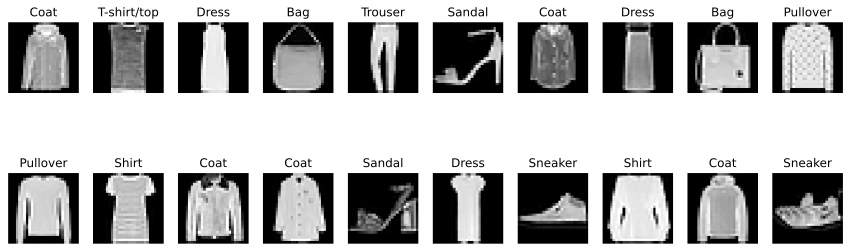

In [24]:
# Select 20 random indices
random_indices = np.random.choice(dataNorm.shape[0], 20, replace=False)

# Get the images corresponding to the random indices
random_images = dataNorm[random_indices]
# Get the labels corresponding to the random indices
random_labels = labels[random_indices]

# Get the class names for the labels
class_names = {v: k for k, v in FMNIST.class_to_idx.items()}

# Plot the images with labels
fig, axes = plt.subplots(2, 10, figsize=(15, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(random_images[i].reshape(28, 28), cmap='gray')
    ax.set_title(f'{class_names[random_labels[i]]}')
    ax.axis('off')  # Hide the axis
plt.show()

In [14]:
# Step 1: convert to tensor
dataT   = torch.tensor( dataNorm ).float()
labelsT = torch.tensor( labels ).long()

# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labelsT, test_size=.1)


# Step 3: convert into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [15]:
# check size (should be images X channels X width X height)
train_loader.dataset.tensors[0].shape

torch.Size([54000, 1, 28, 28])

In [31]:
# create a class for the model
def createTheMNISTNet(printtoggle=False):

  class mnistNet(nn.Module):
    def __init__(self,printtoggle):
      super().__init__()

      ### convolution layers
      self.conv1 = nn.Conv2d( 1,4,kernel_size=4,stride=1,padding=1)
      self.bnorm1 = nn.LazyBatchNorm2d()
      self.conv2 = nn.Conv2d(4,6,kernel_size=4,stride=1,padding=1)
      self.bnorm2 = nn.LazyBatchNorm2d()
      self.conv3 = nn.Conv2d(6,8,kernel_size=4,stride=1,padding=1)
      self.bnorm3 = nn.LazyBatchNorm2d()
      
      self.flat = nn.Flatten()
      
      self.fc1 = nn.LazyLinear(64)
      self.bnorm4 = nn.BatchNorm1d(64)
      self.fc2 = nn.LazyLinear(32)
      self.bnorm5 = nn.BatchNorm1d(32)      
      self.out = nn.Linear(32,10)

      # toggle for printing out tensor sizes during forward prop
      self.print = printtoggle

    # forward pass
    def forward(self,x):

      print(f'Input: {x.shape}') if self.print else None

      # convolution -> maxpool -> relu
      x = self.conv1(x)
      x = F.avg_pool2d(x,2)
      x = self.bnorm1(x)
      x = F.relu(x)
      print(f'Layer conv1/pool1: {x.shape}') if self.print else None     
      
      x = self.conv2(x)
      x = F.avg_pool2d(x,2)
      x = self.bnorm2(x)
      x = F.leaky_relu(x)
      print(f'Layer conv2/pool2: {x.shape}') if self.print else None
      
      x = self.conv3(x)
      x = F.avg_pool2d(x,2)
      x = self.bnorm3(x)
      x = F.leaky_relu(x)
      print(f'Layer conv3/pool3: {x.shape}') if self.print else None     
      
      x = self.flat(x)
      print(f'Flat: {x.shape}') if self.print else None
      
      # linear layers
      x = self.fc1(x)
      x = self.bnorm4(x)
      x = F.relu(x)
      print(f'Layer fc1: {x.shape}') if self.print else None
      
      x = self.fc2(x)
      x = self.bnorm5(x)
      x = F.relu(x)      
      print(f'Layer fc2: {x.shape}') if self.print else None
      
      x = self.out(x)
      
      return x

  # create the model instance
  net = mnistNet(printtoggle)

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001,weight_decay=1e-5)

  return net,lossfun,optimizer

In [32]:
# test the model with one batch
net,lossfun,optimizer = createTheMNISTNet(True)

X,y = next(iter(train_loader))
yHat = net(X)

# check sizes of model outputs and target variable
print(' ')
print(yHat.shape)
print(y.shape)

# now let's compute the loss
loss = lossfun(yHat,y)
print(' ')
print('Loss:')
print(loss)

Input: torch.Size([32, 1, 28, 28])
Layer conv1/pool1: torch.Size([32, 4, 13, 13])
Layer conv2/pool2: torch.Size([32, 6, 6, 6])
Layer conv3/pool3: torch.Size([32, 8, 2, 2])
Flat: torch.Size([32, 32])
Layer fc1: torch.Size([32, 64])
Layer fc2: torch.Size([32, 32])
 
torch.Size([32, 10])
torch.Size([32])
 
Loss:
tensor(2.3610, grad_fn=<NllLossBackward0>)


In [33]:
# count the total number of parameters in the model
summary(net,(1,28,28))

Input: torch.Size([2, 1, 28, 28])
Layer conv1/pool1: torch.Size([2, 4, 13, 13])
Layer conv2/pool2: torch.Size([2, 6, 6, 6])
Layer conv3/pool3: torch.Size([2, 8, 2, 2])
Flat: torch.Size([2, 32])
Layer fc1: torch.Size([2, 64])
Layer fc2: torch.Size([2, 32])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 27, 27]              68
       BatchNorm2d-2            [-1, 4, 13, 13]               8
            Conv2d-3            [-1, 6, 12, 12]             390
       BatchNorm2d-4              [-1, 6, 6, 6]              12
            Conv2d-5              [-1, 8, 5, 5]             776
       BatchNorm2d-6              [-1, 8, 2, 2]              16
           Flatten-7                   [-1, 32]               0
            Linear-8                   [-1, 64]           2,112
       BatchNorm1d-9                   [-1, 64]             128
           Linear-10                   

In [35]:
# a function that trains the model

def function2trainTheModel():

  # number of epochs
  numepochs = 10

  # create a new model
  net,lossfun,optimizer = createTheMNISTNet()

  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    net.train()
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    net.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)

    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )
    
    print(f'Epoch {epochi+1}/{numepochs}, Loss: {losses[epochi]:.4f}, Train Acc: {trainAcc[-1]:.2f}, Test Acc: {testAcc[-1]:.2f}')

  # end epochs

  # function output
  return trainAcc,testAcc,losses,net


In [36]:
trainAcc,testAcc,losses,net = function2trainTheModel()

Epoch 1/10, Loss: 0.6574, Train Acc: 77.14, Test Acc: 82.55
Epoch 2/10, Loss: 0.4672, Train Acc: 82.66, Test Acc: 85.47
Epoch 3/10, Loss: 0.4256, Train Acc: 84.10, Test Acc: 85.67
Epoch 4/10, Loss: 0.4067, Train Acc: 84.88, Test Acc: 86.78
Epoch 5/10, Loss: 0.3903, Train Acc: 85.51, Test Acc: 86.82
Epoch 6/10, Loss: 0.3816, Train Acc: 85.70, Test Acc: 87.18
Epoch 7/10, Loss: 0.3735, Train Acc: 85.90, Test Acc: 86.82
Epoch 8/10, Loss: 0.3663, Train Acc: 86.37, Test Acc: 87.48
Epoch 9/10, Loss: 0.3610, Train Acc: 86.35, Test Acc: 87.58
Epoch 10/10, Loss: 0.3551, Train Acc: 86.71, Test Acc: 87.25


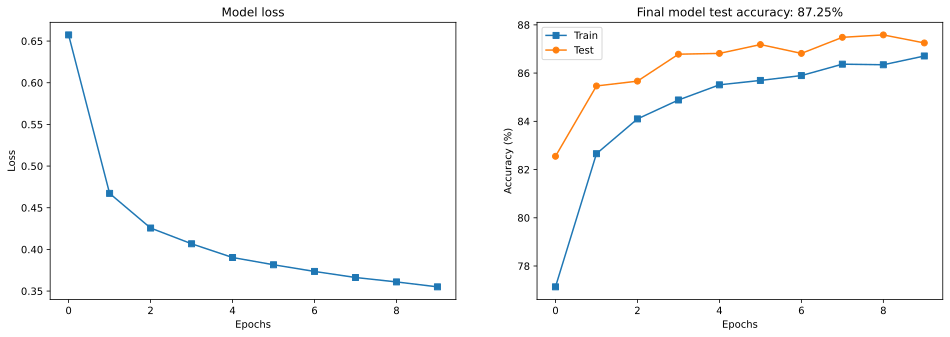

In [37]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses,'s-')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(testAcc,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

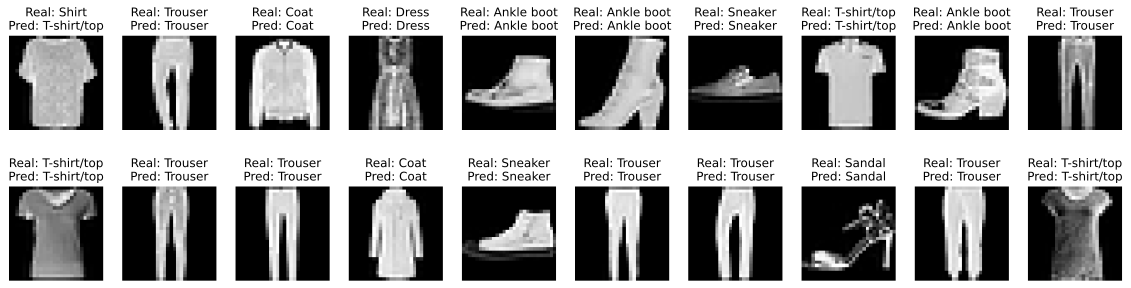

In [39]:
# Get a batch of test data
X, y = next(iter(test_loader))

# Get the model predictions
net.eval()
with torch.no_grad():
    yHat = net(X)

# Convert predictions to class labels
predicted_labels = torch.argmax(yHat, axis=1)

# Plot the images with real and predicted labels
fig, axes = plt.subplots(2, 10, figsize=(20, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(X[i].squeeze(), cmap='gray')
    ax.set_title(f'Real: {class_names[y[i].item()]}\nPred: {class_names[predicted_labels[i].item()]}')
    ax.axis('off')  # Hide the axis
plt.show()

In [40]:
## the real test set!

net.eval() # switch to test mode
X,y = next(iter(test_loader))

# push data to GPU
X = X.to(device)
y = y.to(device)

# forward pass and loss
with torch.no_grad():
  yHat = net(X)
  loss = lossfun(yHat,y)

# loss and accuracy from this batch
testLoss = loss.item()
testAcc  = 100*torch.mean((torch.argmax(yHat,axis=1) == y).float()).item()